In [1]:
import numpy as np
import pandas as pd
import datetime as dt
from matplotlib import pyplot as plt
from kshape.core import kshape, zscore
import minepy
from minepy import MINE
from scipy.stats import spearmanr
import geopandas as gpd

## Global

In [2]:
path="../2021data/"
cci=pd.read_csv(path+'2021_state_cci.csv',index_col = "date")
cases=pd.read_csv(path+"2021_state_cases.csv",index_col="date")
deaths=pd.read_csv(path+"2021_state_deaths.csv",index_col="date")
daily = pd.read_csv(path+"2021_daily_cases.csv",index_col="date")

In [3]:
def get_mic(a,b):
    mine=MINE(est="mic_approx")
    mine.compute_score(a,b)
    return mine.mic()

In [7]:
mic = []
spearman = []
for state in cci.columns:
    x = cci[state]
    y = daily[state]
    m = get_mic(x,y)
    r, p = spearmanr(x, y)
    mic.append(m)
    spearman.append(r)

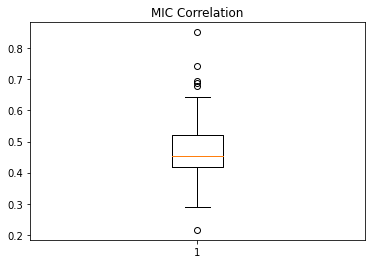

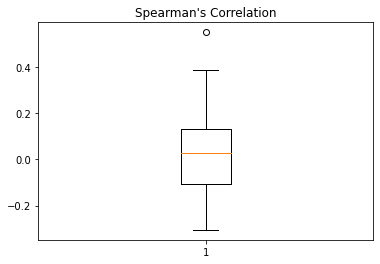

In [8]:
plt.boxplot(mic)
plt.title("MIC Correlation")
plt.show()

plt.boxplot(spearman)
plt.title("Spearman's Correlation")
plt.show()

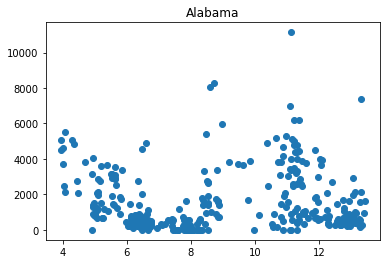

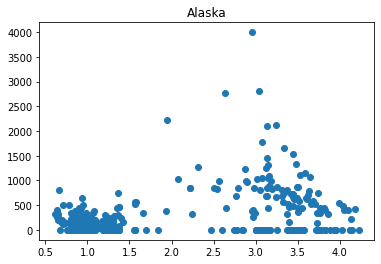

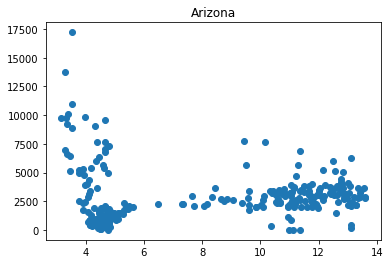

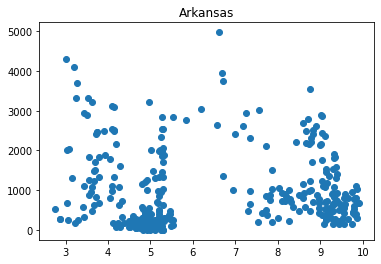

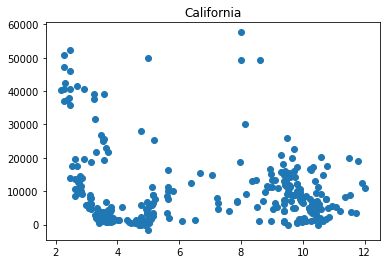

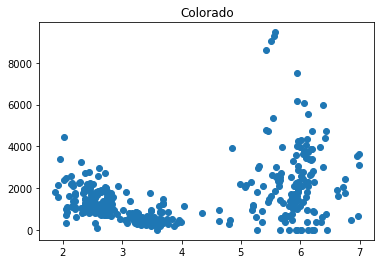

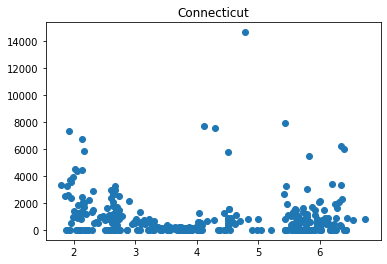

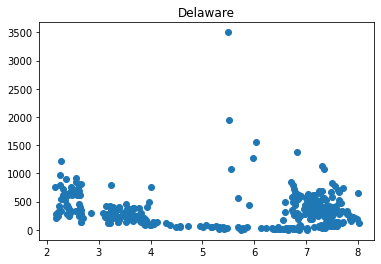

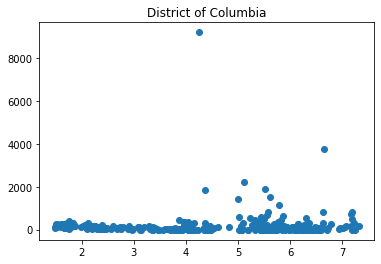

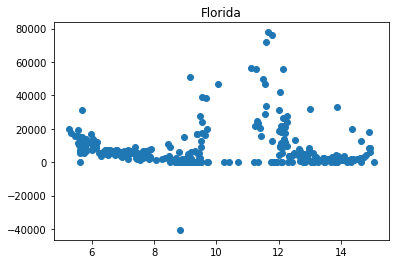

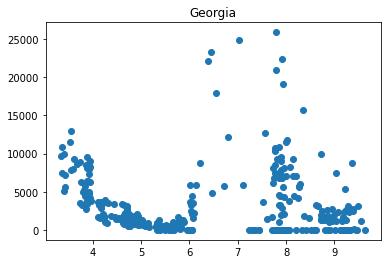

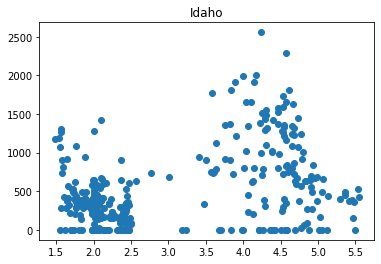

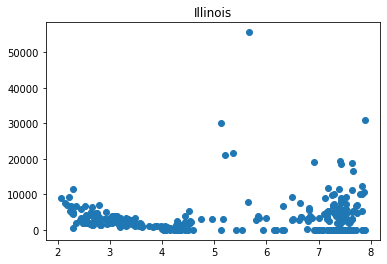

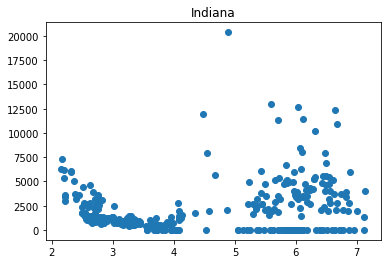

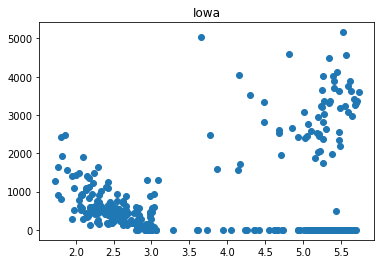

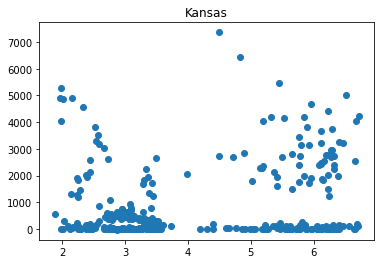

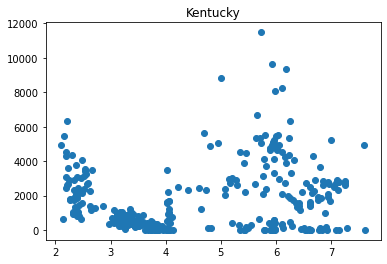

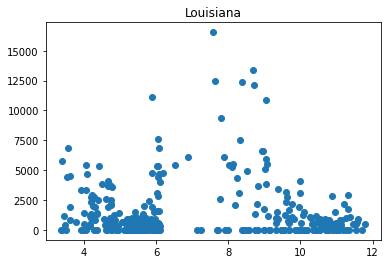

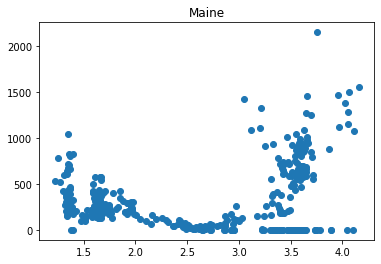

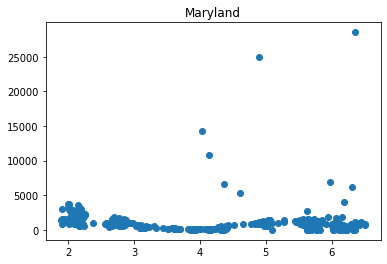

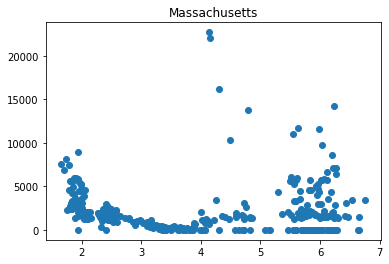

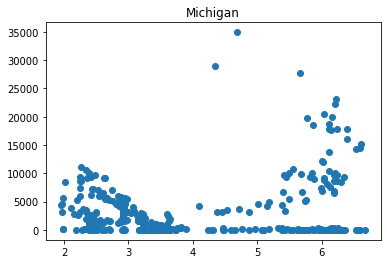

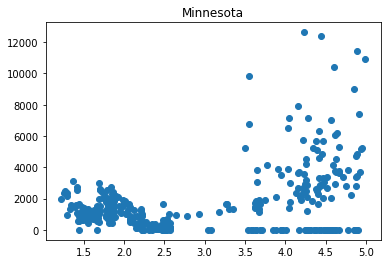

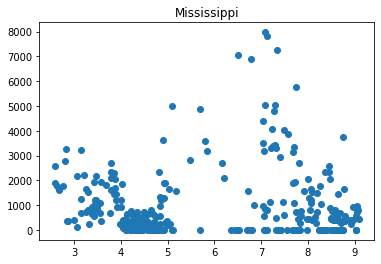

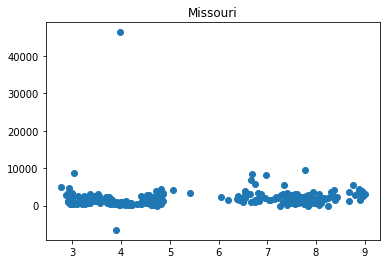

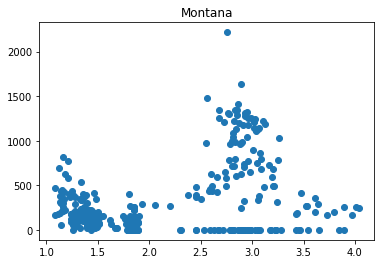

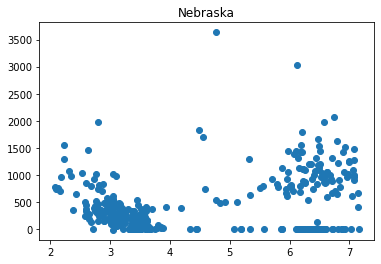

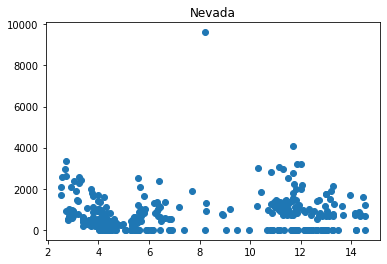

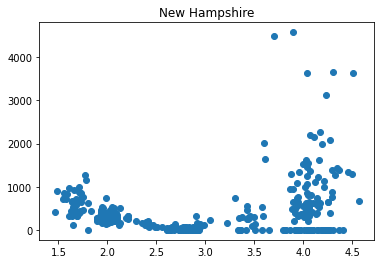

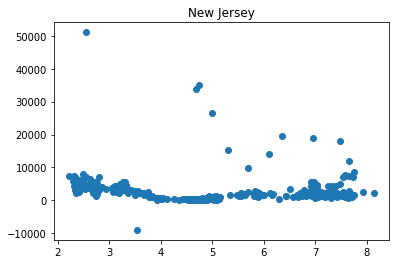

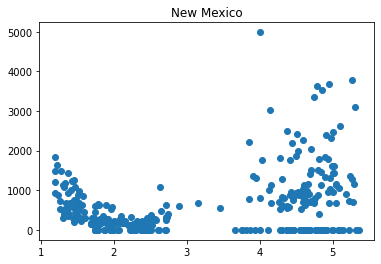

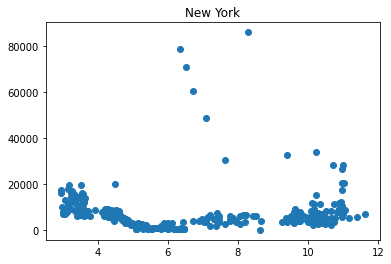

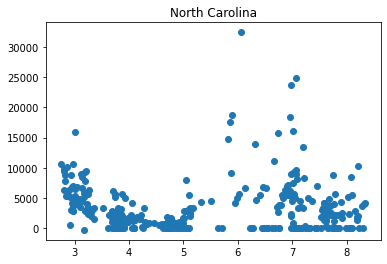

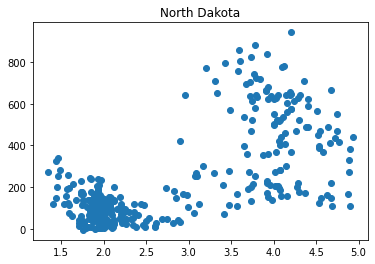

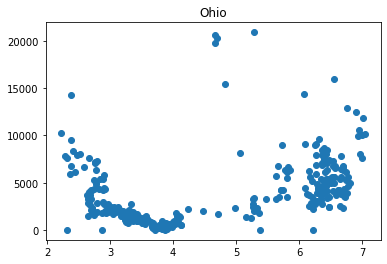

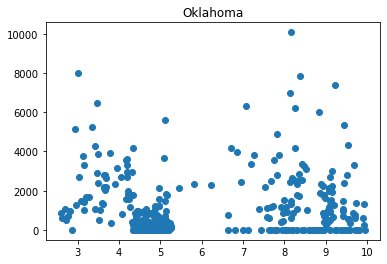

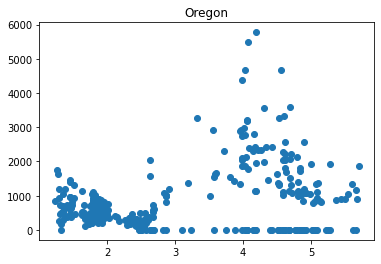

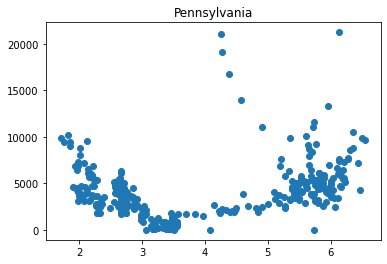

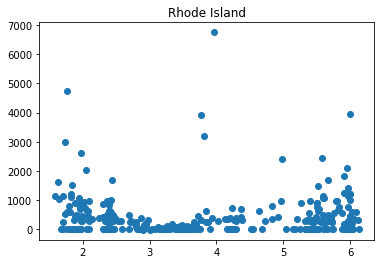

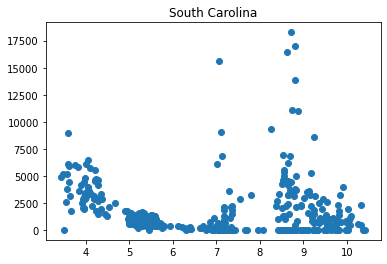

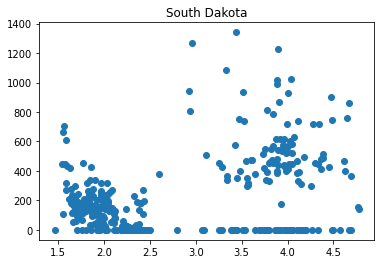

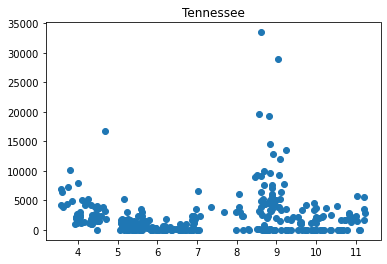

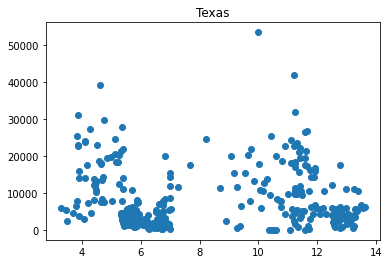

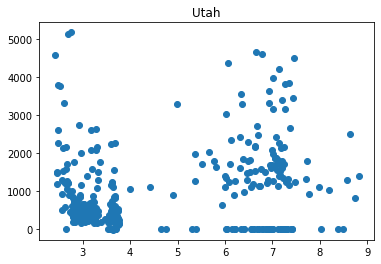

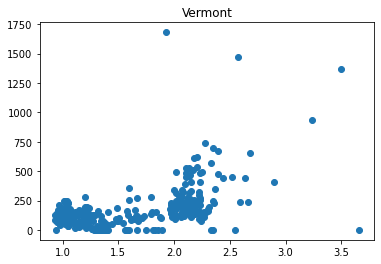

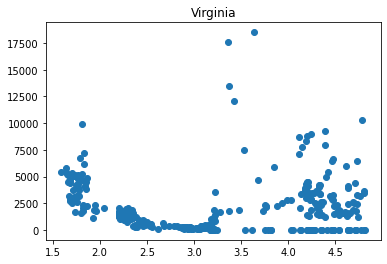

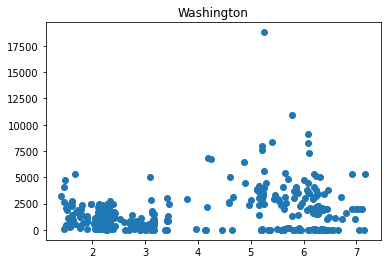

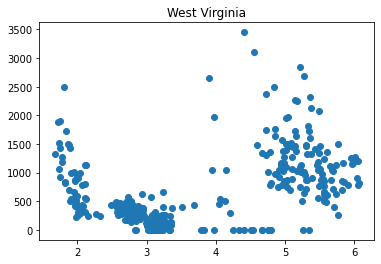

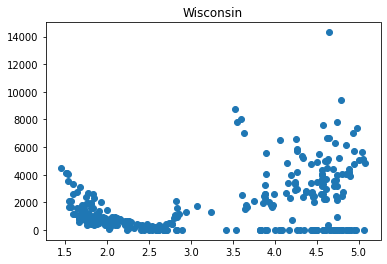

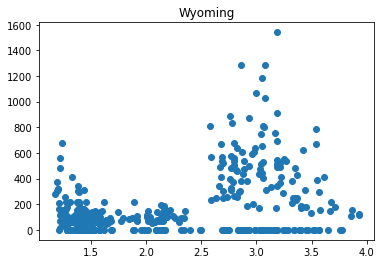

In [9]:
for state in cci.columns:
    plt.scatter(cci[state],daily[state])
    plt.title(state)
    plt.show()

In [11]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [38]:
time_lags = [3,6,9,12,15,18,21]

In [39]:
df = pd.DataFrame()

In [40]:
df.index = cci.columns

In [41]:
for t in time_lags:
    col_mic = []
    for state in df.index:
        x = moving_average(cci[state],t)
        y = moving_average(daily[state],t)
        col_mic.append(get_mic(x,y))
    df[t] = col_mic

In [43]:
df.style.background_gradient(cmap='Blues')

,3,6,9,12,15,18,21
Alabama,0.640800,0.592392,0.572031,0.655034,0.827108,0.785272,0.822905
Alaska,0.573889,0.749322,0.770969,0.774538,0.792998,0.860033,0.883974
Arizona,0.733268,0.829627,0.860838,0.846268,0.857115,0.885406,0.905416
Arkansas,0.455624,0.578750,0.529489,0.548858,0.575824,0.610816,0.698787
California,0.594148,0.554129,0.620333,0.702182,0.754667,0.836674,0.894704
Colorado,0.502450,0.702994,0.714093,0.767349,0.745452,0.764542,0.822971
Connecticut,0.510411,0.666935,0.729826,0.758094,0.803025,0.831183,0.872829
Delaware,0.389474,0.450883,0.517540,0.552067,0.649610,0.666147,0.689955
District of Columbia,0.418177,0.491836,0.560711,0.568197,0.599166,0.607415,0.650199
Florida,0.652357,0.733802,0.776787,0.780836,0.843462,0.868574,0.898648


In [44]:
def kshape_clust(t):
    time_series = []
    for f in t.columns:
        time_series.append(list(t[f]))
    clusters = kshape(zscore(time_series,axis=1),2)
    cluster0=clusters[0][1]
    cluster1=clusters[1][1]
    kshape_labels = []
    for i in range(len(t.columns)):
        if i in cluster0:
            kshape_labels.append(0)
        else:
            kshape_labels.append(1)
    joined_labels=pd.concat([pd.Series(t.columns,name = "state"),pd.Series(kshape_labels,name="label")],axis=1)
    return joined_labels,clusters

In [46]:
lab,c = kshape_clust(cci)

<AxesSubplot:>

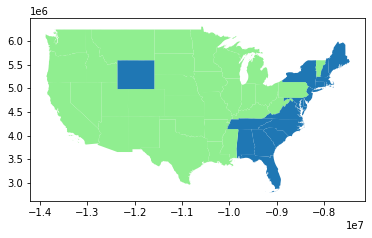

In [50]:
us = gpd.read_file("zip://../2021data/cb_2018_us_state_5m.zip")
fil_func = lambda x: x in ["HI","GU","MP","AS","PR","AK","VI"]
sub_us = us[pd.Series(not fil_func(a) for a in us["STUSPS"])]
sub_us = sub_us.to_crs("EPSG:3395")
partitioned_us = sub_us.merge(lab,left_on = "NAME",right_on="state",how="left")
color_mapping = {0: "tab:blue", 1: "lightgreen"}
partitioned_us.plot(color=partitioned_us["label"].map(color_mapping))

In [53]:
lab = lab.sort_values(by = 'label')

In [58]:
df.reindex(lab["state"]).style.background_gradient(cmap='Blues')

,3,6,9,12,15,18,21
state,,,,,,,
Alabama,0.640800,0.592392,0.572031,0.655034,0.827108,0.785272,0.822905
Virginia,0.632685,0.763242,0.865789,0.833866,0.875325,0.846238,0.877524
Tennessee,0.586721,0.723097,0.801900,0.820591,0.838641,0.889723,0.927423
South Carolina,0.568113,0.725665,0.767540,0.824880,0.860700,0.895613,0.890510
Rhode Island,0.509062,0.714288,0.734217,0.762208,0.797935,0.871285,0.853880
North Carolina,0.622092,0.773679,0.852528,0.853750,0.921977,0.940077,0.969877
New York,0.763650,0.806166,0.862747,0.845095,0.876162,0.897449,0.944071
New Jersey,0.671353,0.733386,0.755821,0.759465,0.790995,0.826077,0.838660
New Hampshire,0.627751,0.800559,0.806149,0.900087,0.930838,0.920513,0.941013


## summer